## Modellierung des Problems:

### Geschäftsmodell eines Unternehmens

* Ein Unternehmen sieht die Preisentwicklung. Sobald es verutet, dass die Preise nicht weiter sinken werden, werden mehrere Flugtickets aufgekauft. Diese können dann, wenn der Preis überall wieder ansteigt günsig weiterverkauuft werden.

### Einfluss auf das Konzept des Modells

theoretisch werden für das Modell viele Vorhersagen benötigt:
* Wann ist das Modell am billigsten / teuersten?
* Was wird der billigste / teuerste Preis sein?
* --> Warten oder kaufen?

## Import

In [ ]:
import pandas as pd 
import numpy as np 
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import gdown

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns_palette = 'rocket'

In [ ]:
gdown.download('https://drive.google.com/uc?id=1lZX1FQC6gD8anqagJBYM8bGW5f2Noolz', output='train_set.csv', quiet=True)
gdown.download('https://drive.google.com/uc?id=1RHwhDVwhF9VAWdBmyY8UlRaAngHDZMKv', output='BrentOilPrices.csv', quiet=True)

'BrentOilPrices.csv'

In [ ]:
#Setzen der Datentypen
dtypes = {'Request_Date':'str', 'Flight_Date':'str', 'Departure_hour':'int', 'flight_unique_id':'str', 'route_abb':'str', 'Price_In_Eur':'float'}
parse_dates = ['Request_Date', 'Flight_Date']
#Import der CSV
df = pd.read_csv('train_set.csv', index_col=0, dtype=dtypes, parse_dates=parse_dates)
#All Spalten als lower case
df.columns = map(str.lower, df.columns)

In [ ]:
def import_oil_price():
  '''Impoortiert den Ölpreis Datensatz und passt das Format/Zeitraum an'''
  parse_dates = ['Date']
  df_oil_price = pd.read_csv('BrentOilPrices.csv', parse_dates=parse_dates)
  df_oil_price = df_oil_price.loc[(df_oil_price['Date'] >= '2019-06-03') & ((df_oil_price['Date'] <= '2019-08-03'))]
  df_oil_price.set_index('Date', inplace=True)
  idx = pd.date_range('2019-06-03', '2019-08-03')
  df_oil_price.index = pd.DatetimeIndex(df_oil_price.index)
  df_oil_price = df_oil_price.reindex(idx, fill_value=np.nan)
  df_oil_price.fillna(method='ffill', inplace=True)
  df_oil_price = df_oil_price.reset_index()
  df_oil_price.columns = ['request_date', 'oil_price']
  df_oil_price['request_date'] = df_oil_price['request_date'].dt.date
  return df_oil_price

## Deskriptive Analyse vorhandener Spalten

In [ ]:
def set_fig_ax(title, xlabel, ylabel):
  '''Erstellt den Canvas und setzt Titel sowie Achsenbeschriftung'''
  fig, ax = plt.subplots(figsize=(15, 10))
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  return fig, ax

### Allgemein

In [ ]:
df.head()

,request_date,flight_date,departure_hour,flight_unique_id,route_abb,price_in_eur
1,2019-06-03 11:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07
2,2019-06-03 23:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07
3,2019-06-04 11:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07
4,2019-06-04 23:00:00+00:00,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07
5,2019-06-03 11:00:00+00:00,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86


In [ ]:
df.shape

(83624, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83624 entries, 1 to 83624
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   request_date      83624 non-null  datetime64[ns, UTC]
 1   flight_date       83624 non-null  datetime64[ns]     
 2   departure_hour    83624 non-null  int64              
 3   flight_unique_id  83624 non-null  object             
 4   route_abb         83624 non-null  object             
 5   price_in_eur      83624 non-null  float64            
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.5+ MB


* Es gibt keine NA Werte im gesamten Datensatz
* Die Datentypen wurden bereits beim Import angepasst

In [ ]:
df.describe()

,departure_hour,price_in_eur
count,83624.000000,83624.000000
mean,12.969889,71.965080
std,6.177936,54.788483
min,6.000000,8.990000
25%,7.000000,32.770000
50%,10.000000,55.080000
75%,19.000000,91.790000
max,22.000000,372.960000


### Request date

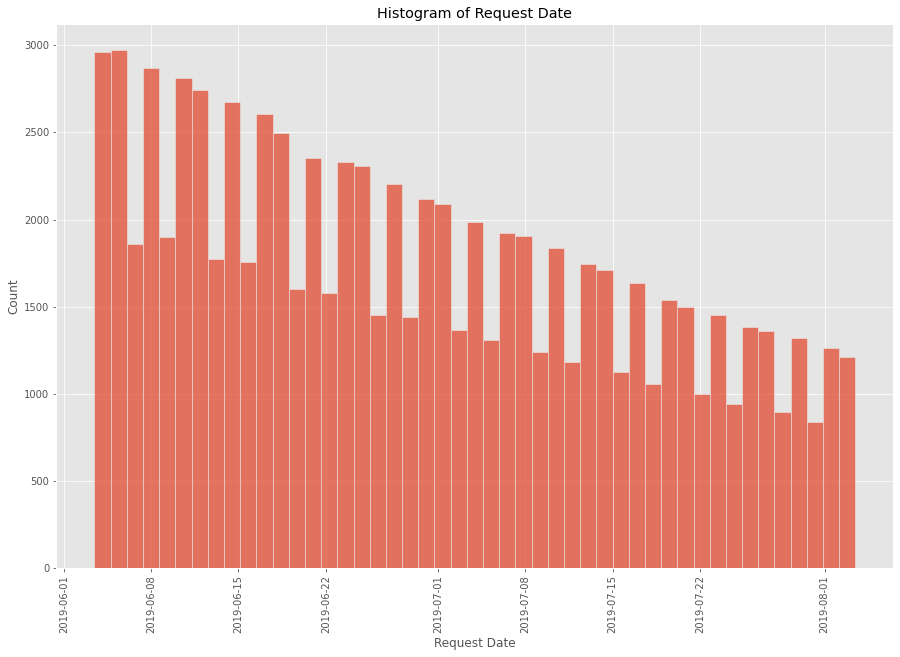

In [ ]:
fig, ax = set_fig_ax('Histogram of Request Date', 'Request Date', 'Count')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.histplot(x='request_date',  data=df, palette=sns_palette)

In [ ]:
df.request_date.min()

Timestamp('2019-06-03 11:00:00+0000', tz='UTC')

In [ ]:
df.request_date.max()

Timestamp('2019-08-03 11:00:00+0000', tz='UTC')

* von 3.8.2019 bis 3.6.2019
* mehr Werte für den Juni, als für August
* datetime

### Flight_date

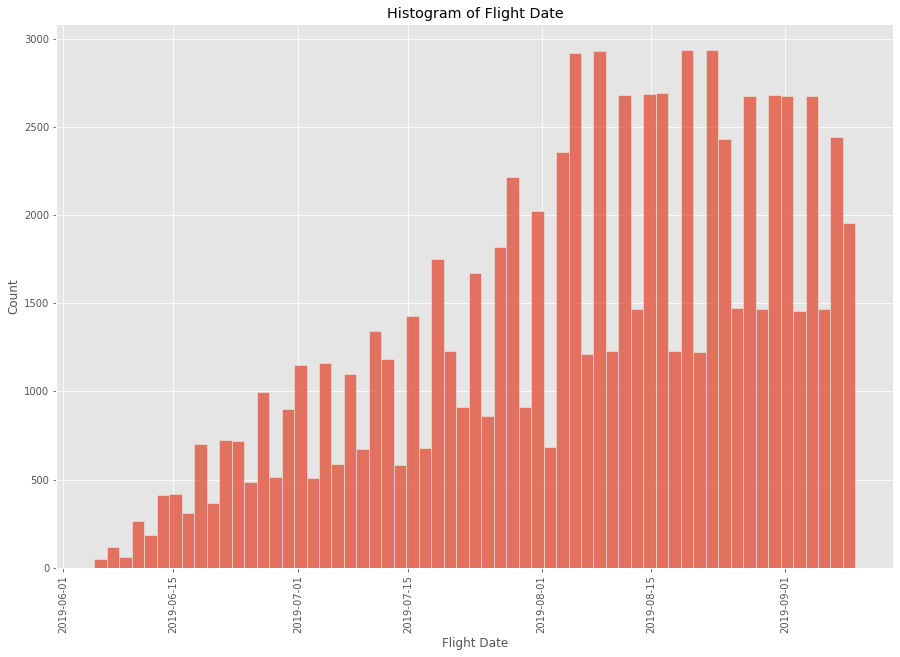

In [ ]:
fig, ax = set_fig_ax('Histogram of Flight Date', 'Flight Date', 'Count')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
ax = sns.histplot(x='flight_date',  data=df, palette=sns_palette)

In [ ]:
df.flight_date.min()

Timestamp('2019-06-05 00:00:00')

In [ ]:
df.flight_date.max()

Timestamp('2019-09-10 00:00:00')

* Zeitraum vom 5.6.2019 bis zum 10.9.2019
* Mehr Flüge im September als im Juni

### Departure hour


In [ ]:
df.groupby('departure_hour', as_index=False)[['flight_unique_id']].count().sort_values(by='departure_hour', ascending=True, ignore_index=True)

,departure_hour,flight_unique_id
0,6,17811
1,7,14644
2,8,4123
3,9,91
4,10,6554
5,18,12951
6,19,20073
7,21,922
8,22,6455


* Werte: 6,7,8,9,10,18,19,21,22
* Datentyp: int

### Flight unique ID

In [ ]:
df["flight_unique_id"].value_counts()

2019-08-06 FR 8543    123
2019-09-10 FR 145     123
2019-08-11 FR 145     123
2019-08-20 FR 8545    123
2019-08-18 FR 8543    123
                     ... 
2019-06-30 FR 146       4
2019-06-05 FR 146       4
2019-06-05 FR 147       4
2019-06-05 FR 8545      4
2019-06-06 FR 1547      4
Name: flight_unique_id, Length: 1007, dtype: int64

* 1007 Flüge werden untersucht
* Datentyp: string

### Route abb

In [ ]:
df.groupby('route_abb', as_index=False)[['flight_unique_id']].count().sort_values(by='flight_unique_id', ascending=False, ignore_index=True)

,route_abb,flight_unique_id
0,SXF-STN,27592
1,STN-SXF,26489
2,FRA-STN,14950
3,STN-FRA,14593


* Werte: FRA-STN (14950x), STN-FRA(14593x), STN-SXF(26489x), SXF-STN(27592x)
* Deutlich mehr Flüge nach Berlin und London, als nach Frankfurt
* Datentyp: string

### Price in eur

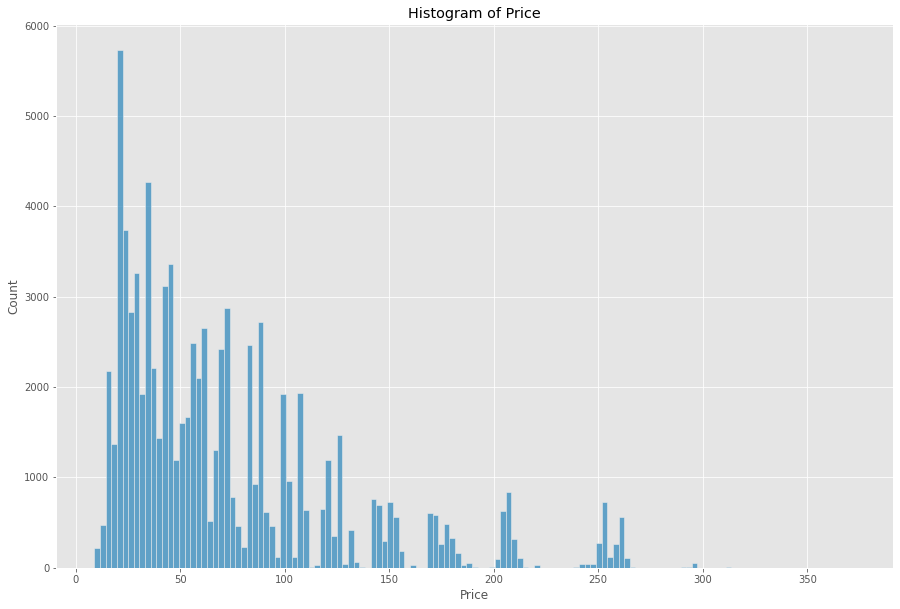

In [ ]:
fig, ax = set_fig_ax('Histogram of Price', 'Price', 'Count')
ax = sns.histplot(x='price_in_eur',  data=df, palette=sns_palette)

In [ ]:
df.price_in_eur.min()

8.99

In [ ]:
df.price_in_eur.max()

372.96

* Werte von 8,99 € bis 372,96 €
* Großteil der Preise im niedrigen Bereich; selten hohe Preise
* Datentyp: int

## Deskriptive Analyse neuer Spalten

### Erstellung der neuen Spalten

* Die folgenden neuen Spalten sind grundsätzlich schon in den Daten vorhanden und müssen nur berechnet werden
* Zusätzlich zu neuen abgeleiteten Spalten wird das Feature "route_abb" one-hot-encoded

In [ ]:
df['request_hour'] = df['request_date'].apply(lambda date:date.hour)
df['request_date'] = df['request_date'].dt.date
df['flight_date'] = df['flight_unique_id'].apply(lambda id:datetime.strptime(id.split()[0], '%Y-%m-%d').date())
df['flight_month'] = df['flight_date'].apply(lambda date:date.month)
df["request_month"] = df['request_date'].apply(lambda date:date.month)
df['flight_weekday'] = df['flight_date'].apply(lambda date:date.weekday())
df['request_weekday'] = df['request_date'].apply(lambda date:date.weekday())
df['days_to_dept'] = (df['flight_date'] - df['request_date'])
df['days_to_dept'] = df['days_to_dept'].dt.days.astype('int16')
df= pd.concat([df, pd.get_dummies(df['route_abb'])], axis=1)

In [ ]:
#Zelle erstellt eine Spalte later_min; diese sagt aus, ob ein Flug später noch günstiger wird oder nicht
df["id"]=df.index
unique_flights=list(set(df["flight_unique_id"]))
true_ids=[]
for x in unique_flights:
    rows=df[df["flight_unique_id"]==x]
    rows.sort_values(["request_date","request_hour"],ascending=[True,True],inplace=True)
    rows.reset_index(drop=True,inplace=True)
    min_price_index=rows[["price_in_eur"]].idxmin() 
    true_ids.append(list(rows["id"][:min_price_index[0]]))
true_ids = list(itertools.chain.from_iterable(true_ids))
df['later_min'] = df.id.isin(true_ids).astype(int) 
df.drop(['id'], axis=1, inplace=True)   

* Die folgenden Spalten geben an, ob während der Zeit des Fluges Ferien sind

* Ferien Berlin 20.06.2019 - 02.08.2019
* Ferien Frankfurt 01.07.2019 - 09.08.2019
* Ferien London 15.07.2019 - 06.09.2019

In [ ]:
df["ferien_berlin"]=np.where((df.flight_date >= date(2019, 6, 20))&
    (df.flight_date <= date(2019, 8, 2)), 1, 0)
     #& ((df.route_abb == "SXF-STN")|(df.route_abb == "STN-SXF")) , 1, 0)

In [ ]:
df["ferien_frankfurt"]=np.where((df.flight_date >= date(2019, 7, 1))&
    (df.flight_date <= date(2019, 8, 9)) , 1, 0)
    #& ((df.route_abb == "FRA-STN")|(df.route_abb == "STN-FRA")) , 1, 0)

In [ ]:
df["ferien_london"]=np.where((df.flight_date >= date(2019, 7, 15))&
    (df.flight_date <= date(2019, 9, 6)) , 1, 0)

* Die folgende Spalte stellt den Ölpreis da, welcher aus einer anderen Tabelle übernommen wird
* Es soll untersucht werden, on der Ölpreis mit Flugpreisen korreliert

In [ ]:
df_oil_price = import_oil_price()

In [ ]:
df_oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   request_date  62 non-null     object 
 1   oil_price     62 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
df = pd.merge(df, df_oil_price, how='left', on='request_date')

* Endprodukt:

In [ ]:
df.head()

,request_date,flight_date,departure_hour,flight_unique_id,route_abb,price_in_eur,request_hour,flight_month,request_month,flight_weekday,request_weekday,days_to_dept,FRA-STN,STN-FRA,STN-SXF,SXF-STN,later_min,ferien_berlin,ferien_frankfurt,ferien_london,oil_price
0,2019-06-03,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,11,6,6,2,0,2,0,0,0,1,0,0,0,0,63.16
1,2019-06-03,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,23,6,6,2,0,2,0,0,0,1,0,0,0,0,63.16
2,2019-06-04,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,11,6,6,2,1,1,0,0,0,1,0,0,0,0,63.56
3,2019-06-04,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,23,6,6,2,1,1,0,0,0,1,0,0,0,0,63.56
4,2019-06-03,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,11,6,6,2,0,2,0,0,1,0,0,0,0,0,63.16


### Gruppierung nach Request Hour

In [ ]:
df.groupby('request_hour', as_index=False)[['flight_unique_id']].count().sort_values(by='request_hour', ascending=True, ignore_index=True)

,request_hour,flight_unique_id
0,11,41985
1,23,41639


* Werte: 11, 23
* Datentyp: int

### Gruppierung nach Flight Month

In [ ]:
df.groupby('flight_month', as_index=False)[['flight_unique_id']].count().sort_values(by='flight_month', ascending=True, ignore_index=True)

,flight_month,flight_unique_id
0,6,7242
1,7,22758
2,8,40952
3,9,12672


* Werte: 6,7,8,9
* Datentyp: int

### Gruppierung nach Request Month

In [ ]:
df.groupby('request_month', as_index=False)[['flight_unique_id']].count().sort_values(by='request_month', ascending=True, ignore_index=True)

,request_month,flight_unique_id
0,6,47529
1,7,34047
2,8,2048


* Werte: 6,7,8
* Datentyp: int

### Gruppierung nach Flight Weekday

In [ ]:
df_fw=df.groupby('flight_weekday', as_index=False)[['flight_unique_id']].count().sort_values(by='flight_weekday', ascending=True, ignore_index=True)
df_fw

,flight_weekday,flight_unique_id
0,0,13758
1,1,12510
2,2,10625
3,3,12701
4,4,12264
5,5,10884
6,6,10882


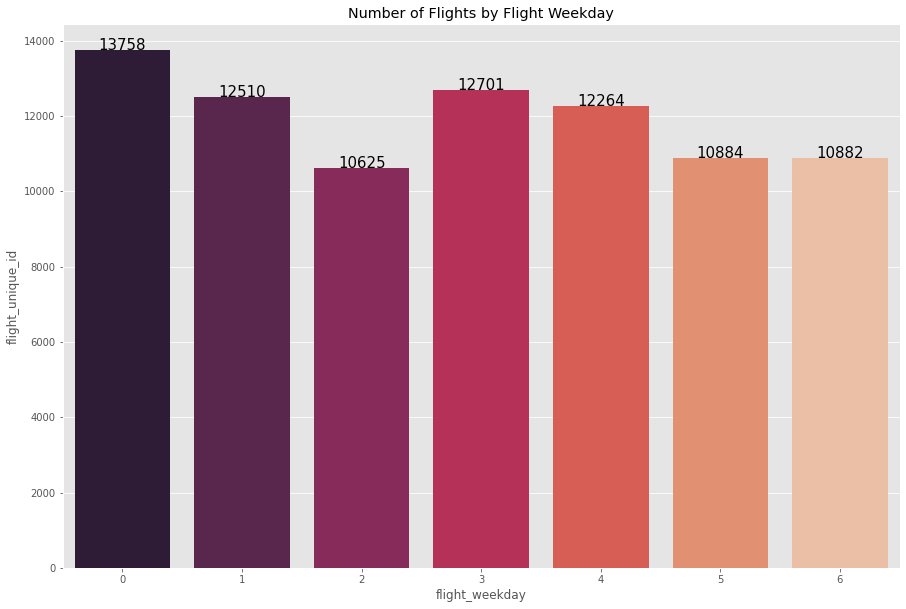

In [ ]:
fig, ax = set_fig_ax('Number of Flights by Flight Weekday', 'Flight Weekday', 'Flight ID')
ax = sns.barplot(x="flight_weekday",y="flight_unique_id", data= df_fw, palette=sns_palette)
for index, row in df_fw.iterrows():
  ax.text(row.name, row.flight_unique_id, row.flight_unique_id,color="black", ha="center", fontsize=15)

* Werte: 0,1,2,3,4,5,6
* 0 = Montag
* Datentyp: int

### Gruppierung nach Request Weekday

In [ ]:
df_rw=df.groupby('request_weekday', as_index=False)[['flight_unique_id']].count().sort_values(by='request_weekday', ascending=True, ignore_index=True)
df_rw

,request_weekday,flight_unique_id
0,0,12750
1,1,12504
2,2,12227
3,3,11935
4,4,11936
5,5,11380
6,6,10892


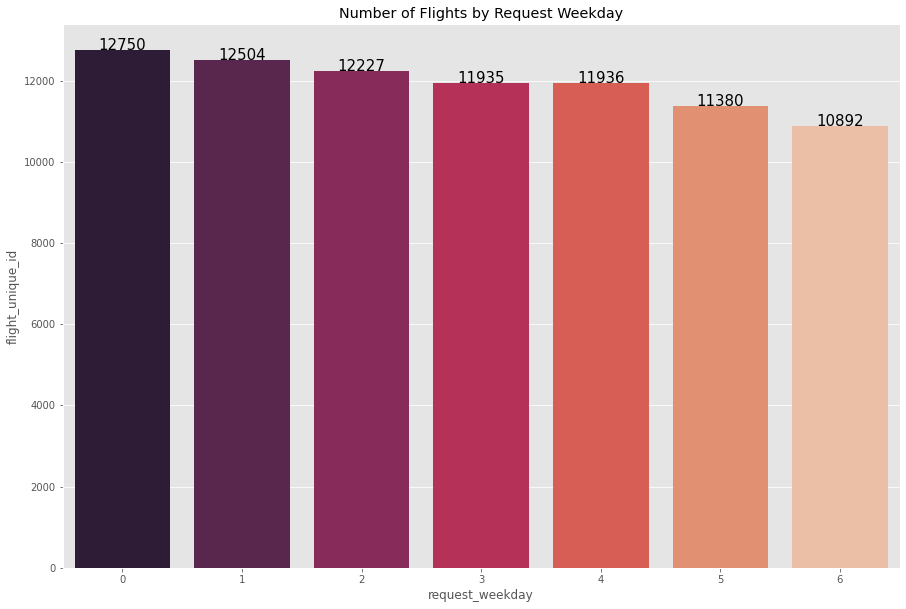

In [ ]:
fig, ax = set_fig_ax('Number of Flights by Request Weekday', 'Request Weekday', 'Flight ID')
ax = sns.barplot(x="request_weekday",y="flight_unique_id", data= df_rw, palette=sns_palette)
for index, row in df_rw.iterrows():
  ax.text(row.name, row.flight_unique_id,row.flight_unique_id, color="black", ha="center", fontsize=15)

* Werte: 0,1,2,3,4,5,6
* 0 = Montag
* Datentyp: int

### Gruppierung nach Days to Departure

In [ ]:
df.groupby('days_to_dept')[['price_in_eur']].mean()

,price_in_eur
days_to_dept,
1,181.356509
2,175.990235
3,166.882764
4,160.103308
5,148.752836
...,...
95,30.926304
96,30.774286
97,32.475962



* Werte: 1-99
* Preis wird höher je näher der Flug rückt
* Datentyp: int

## Korrelation

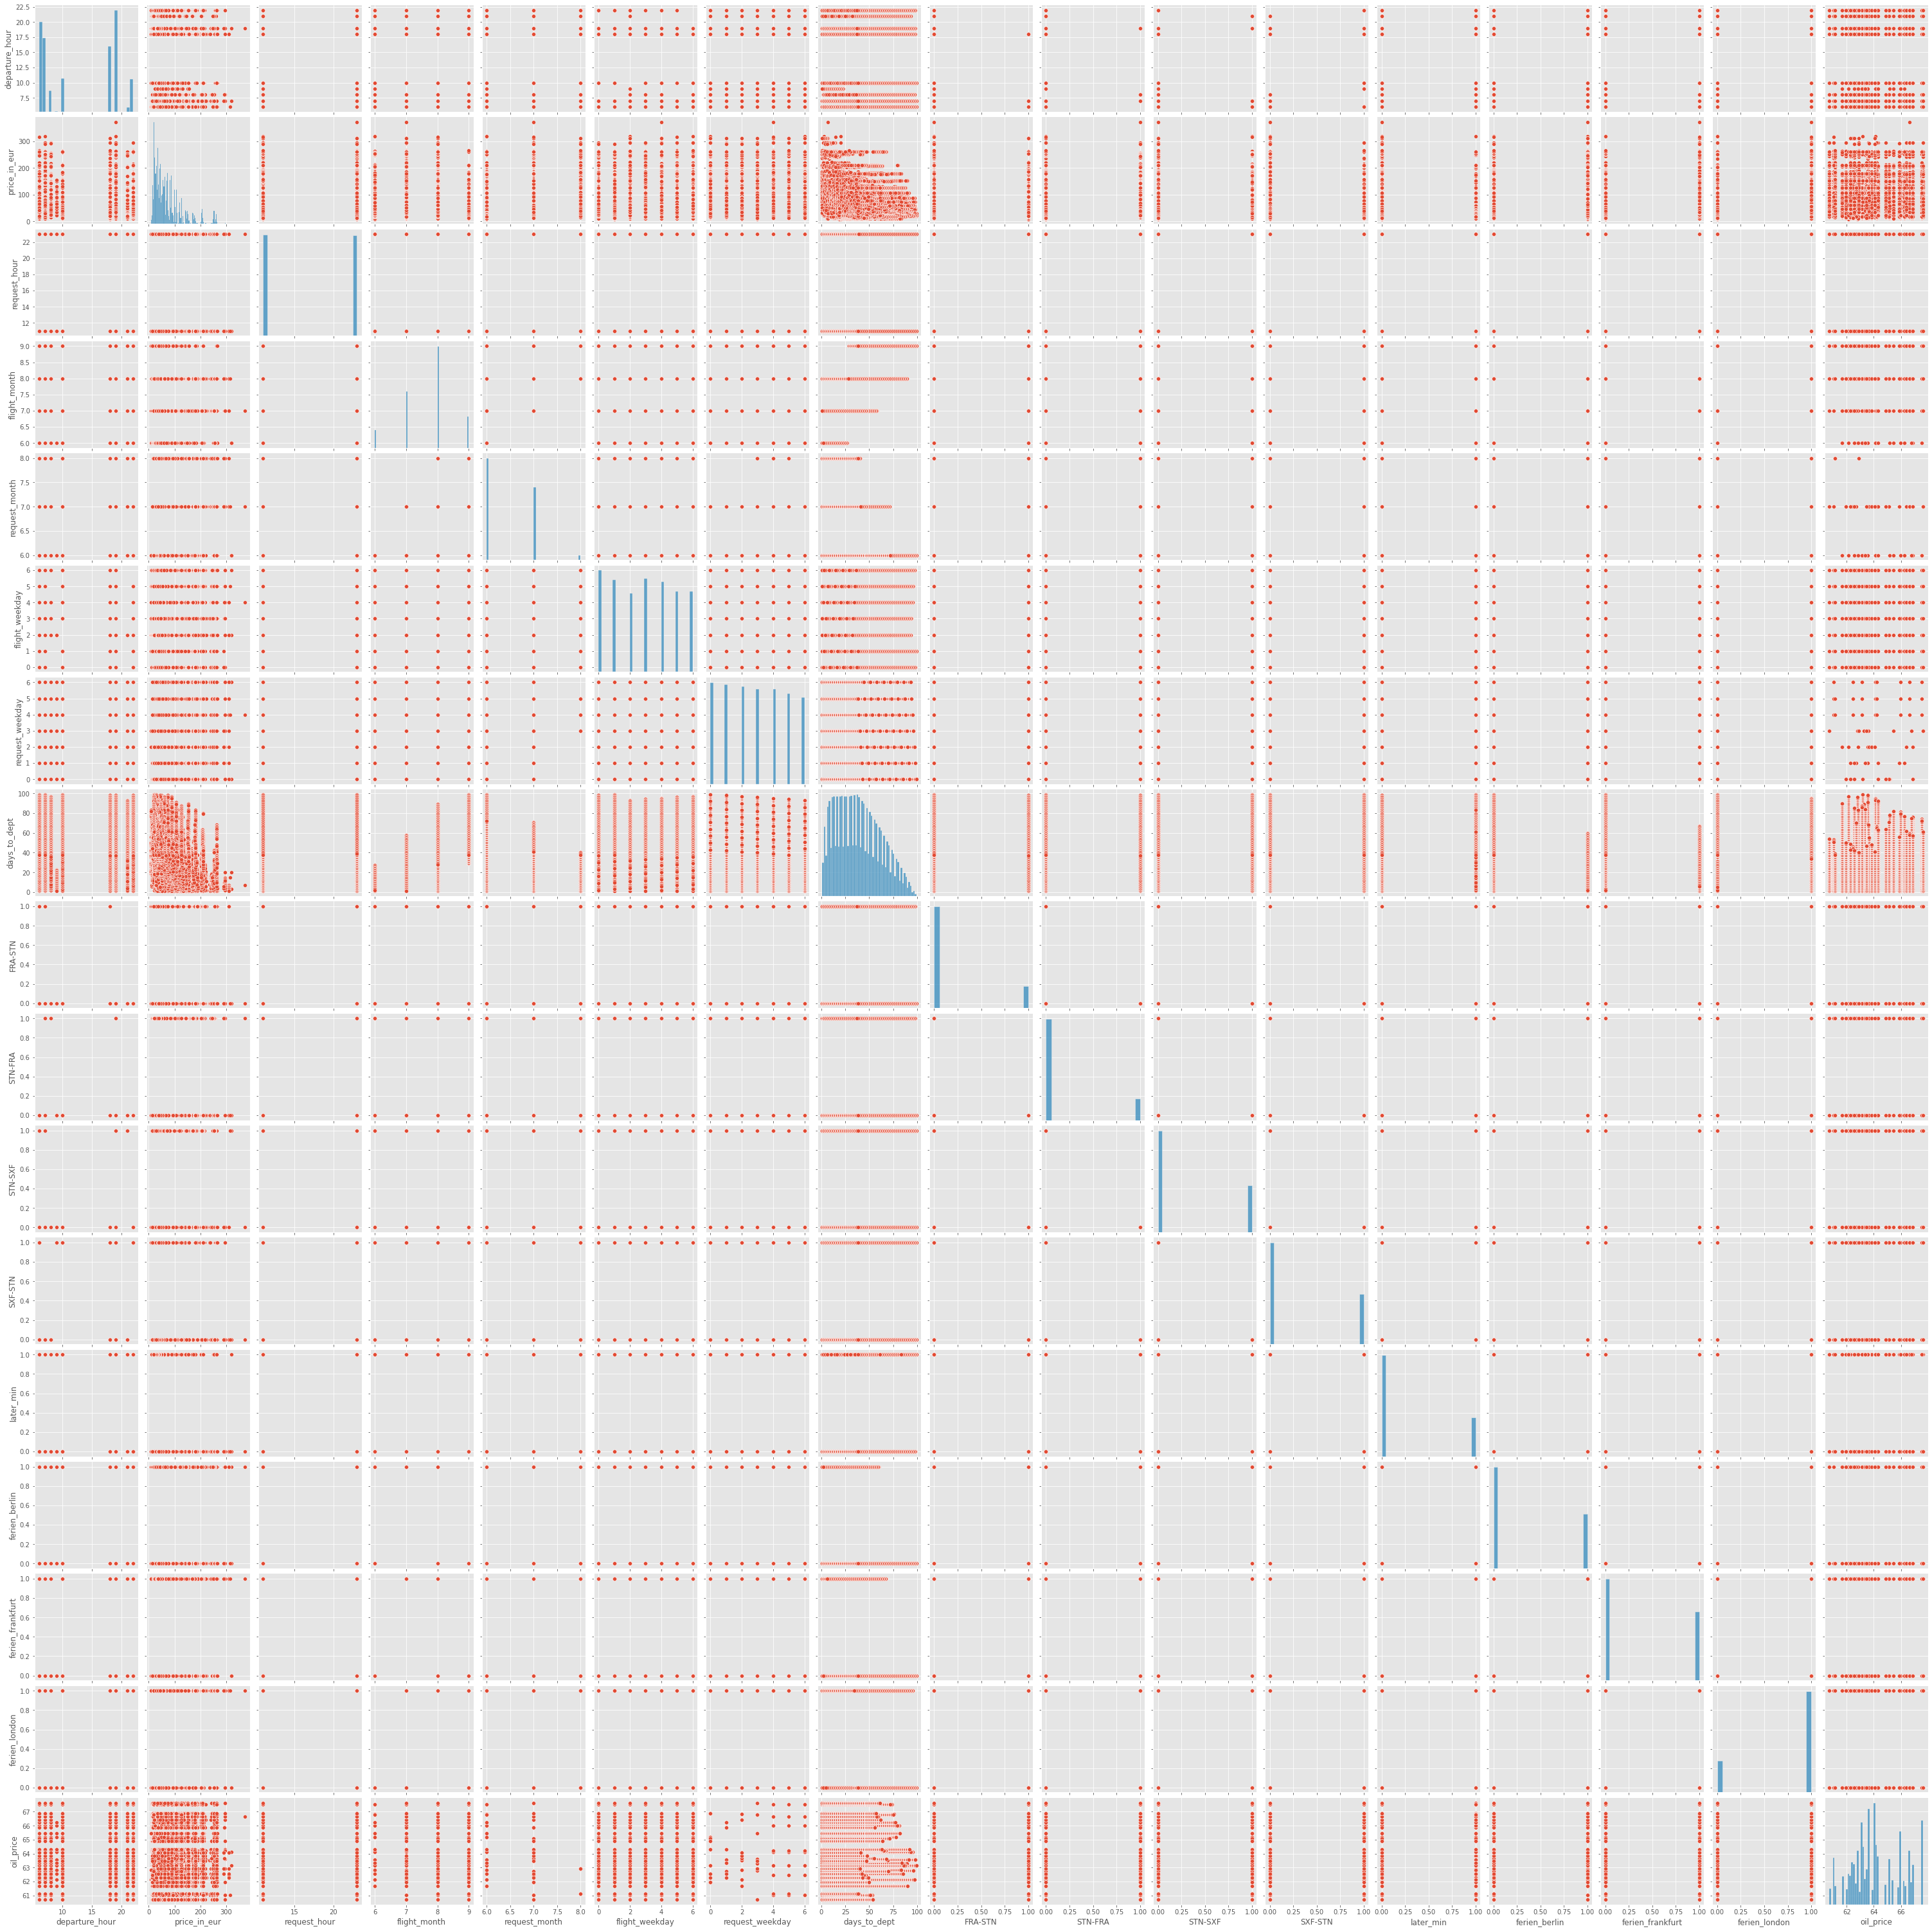

In [ ]:
sns.pairplot(df)

* Leichte Koorelationen bei depature_hour, days_to_dept erkennbar

* Es wurde ein häufig vorkommender Flug ausgewäht, damit Punkte besser erkannt werden können:

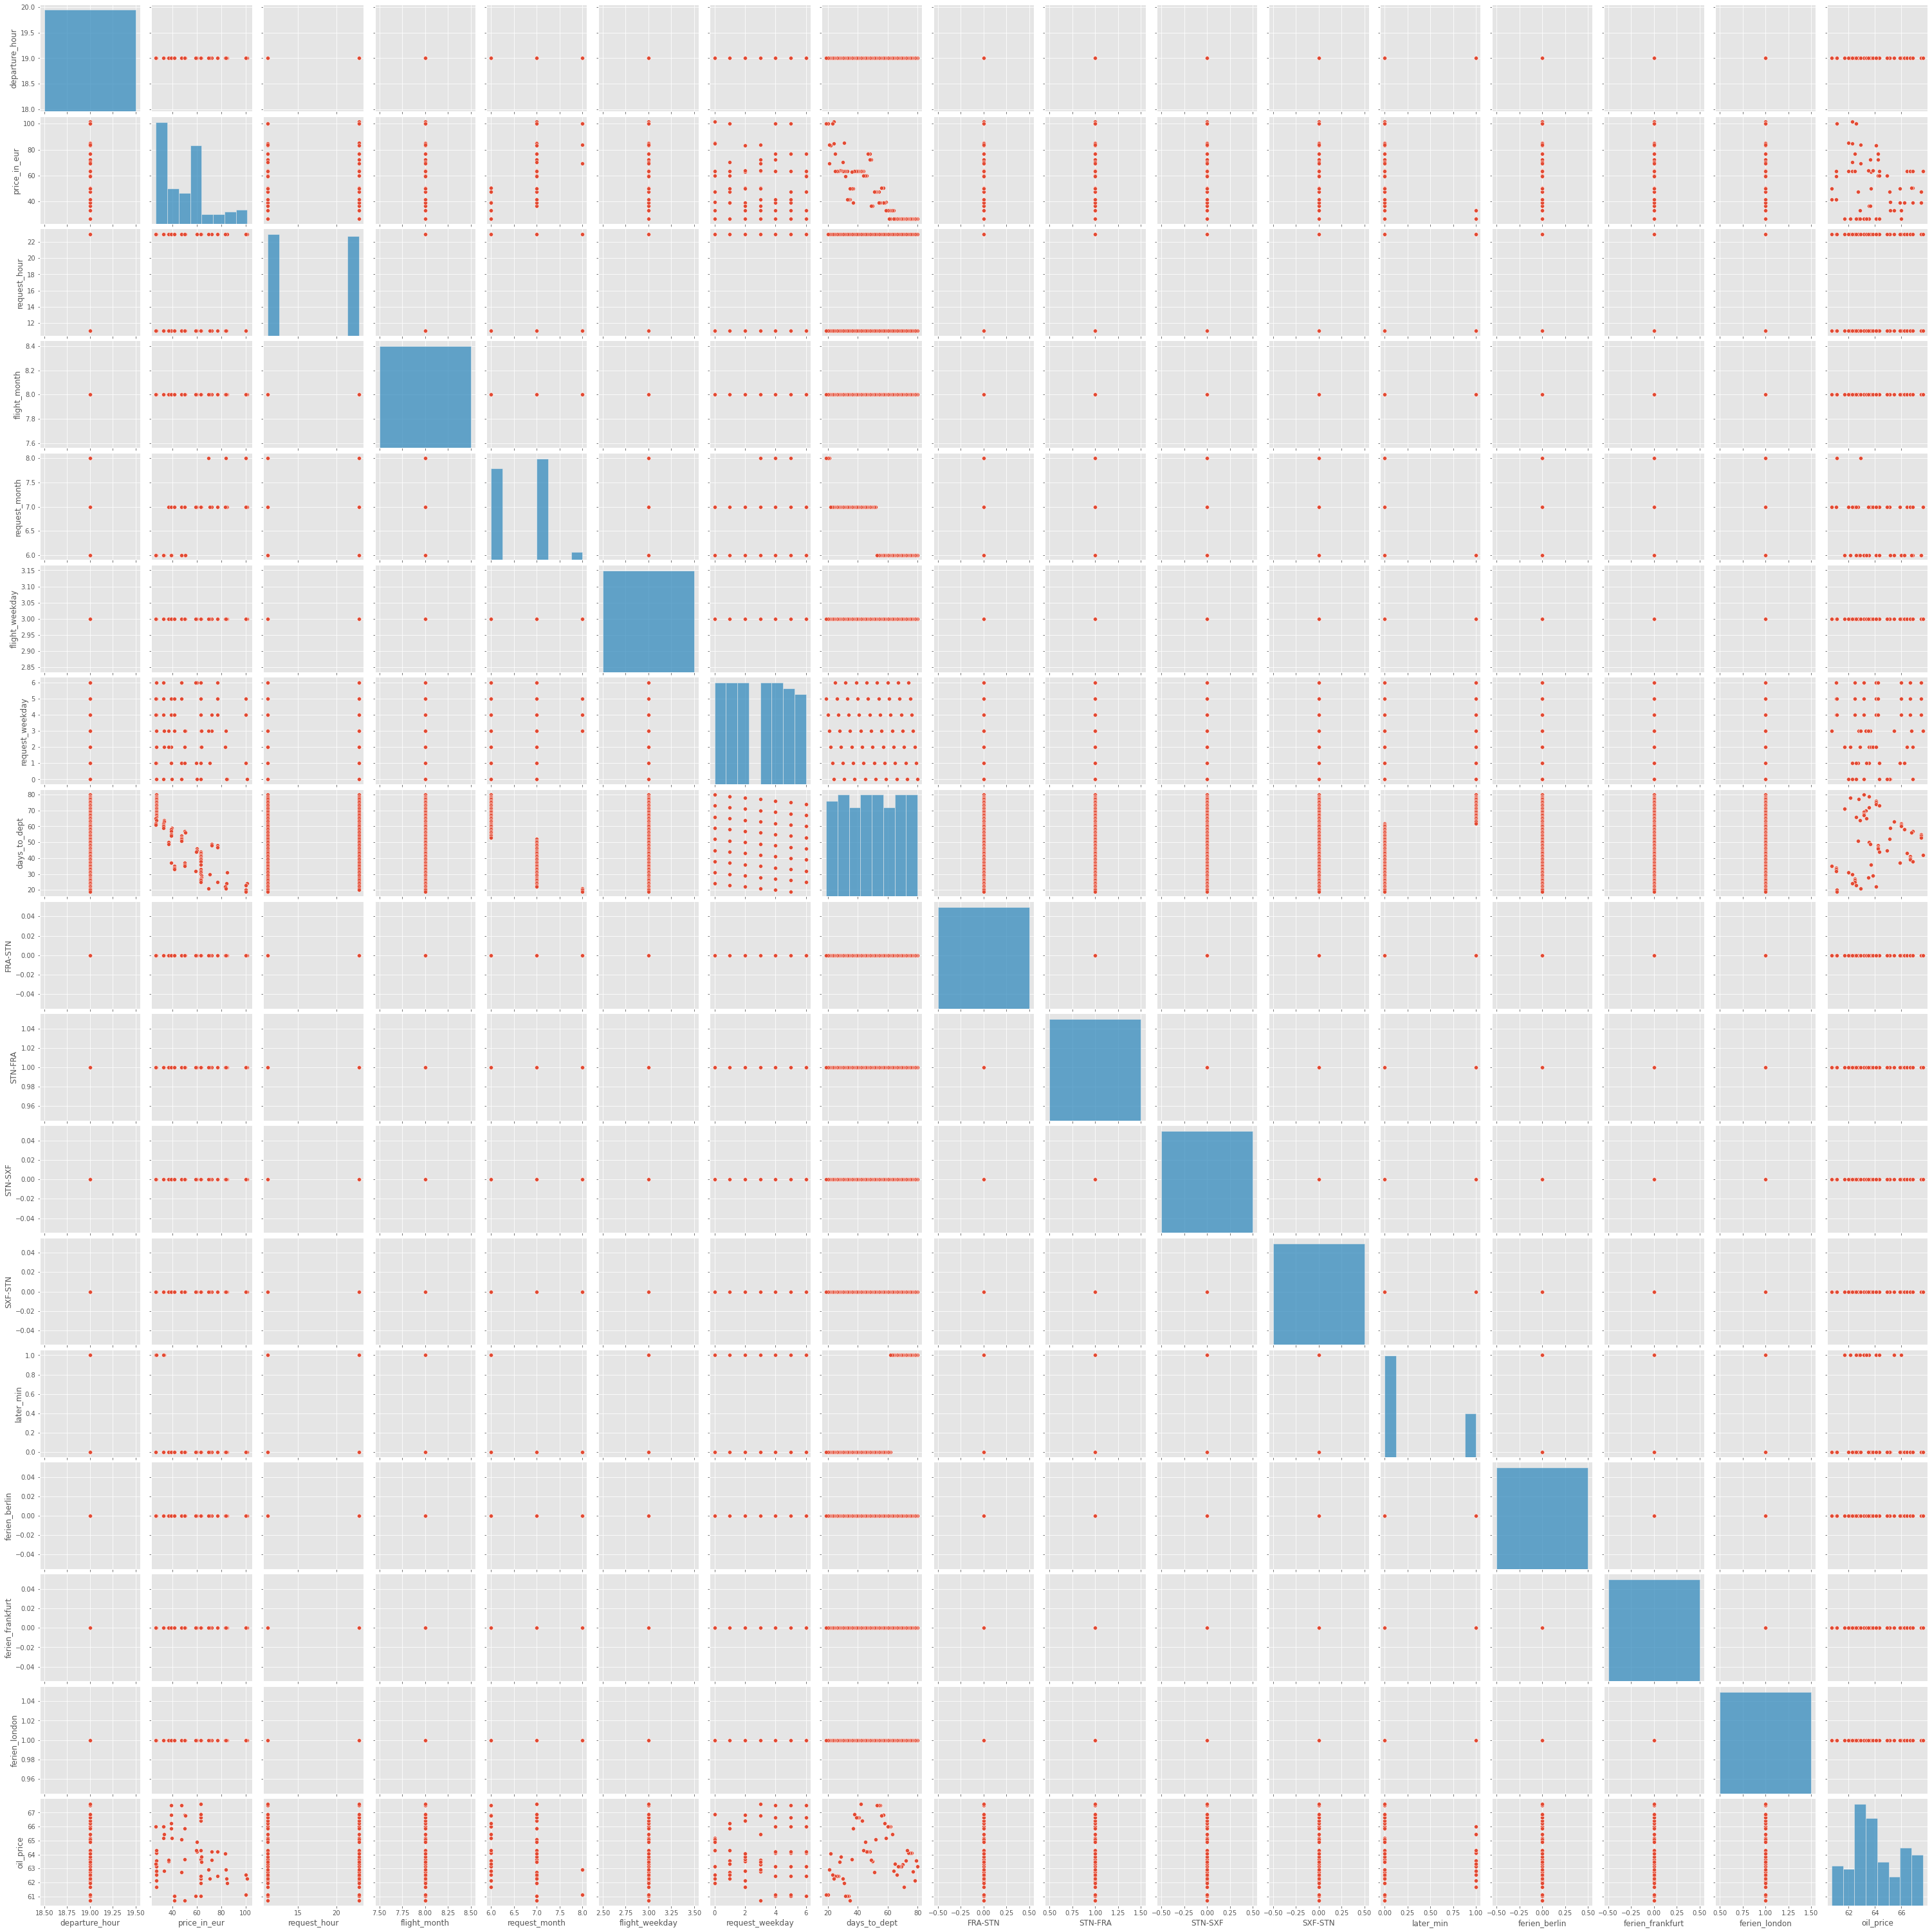

In [ ]:
sns.pairplot(df[df["flight_unique_id"]=="2019-08-22 FR 1547"])

* Zusätzliche Korrelation bei request_month sichtbar

* Folgend eine andere Darstellung der Korrelation für alle Werte

In [ ]:
df.corr().iloc[1,:].sort_values(ascending=False)

price_in_eur        1.000000
ferien_berlin       0.295627
ferien_frankfurt    0.218074
request_month       0.166957
flight_weekday      0.121191
departure_hour      0.092180
STN-SXF             0.067320
SXF-STN             0.036132
oil_price           0.013475
request_weekday     0.009124
request_hour        0.000362
STN-FRA            -0.036898
FRA-STN            -0.089526
ferien_london      -0.170810
later_min          -0.290658
flight_month       -0.375585
days_to_dept       -0.515541
Name: price_in_eur, dtype: float64

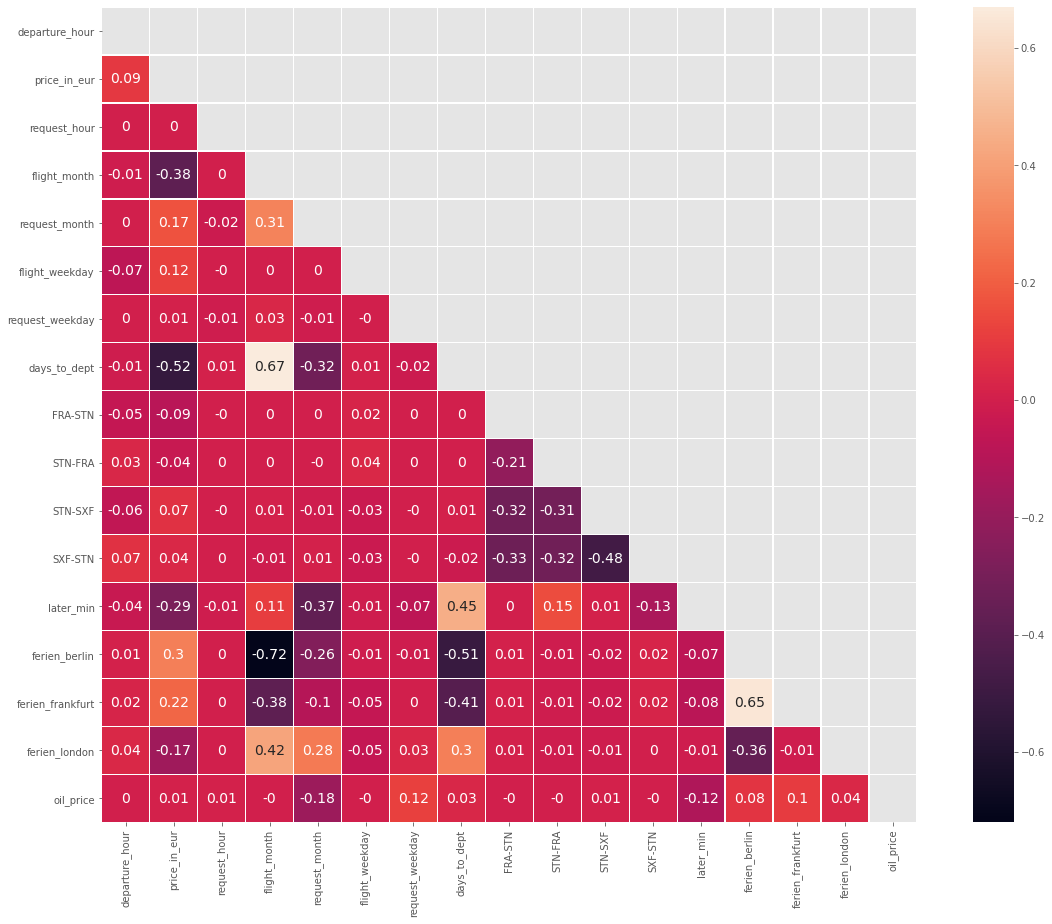

In [ ]:
corr = df.corr()
corr = corr.round(2)

fig, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, square = True, linewidths = 0.5, annot=True, annot_kws={"size": 14}, cmap="rocket")

* Höchste Korrelation bei days_to_departure, flight_month, ferien_berin, later_min und ferien_frankfurt sichtbar

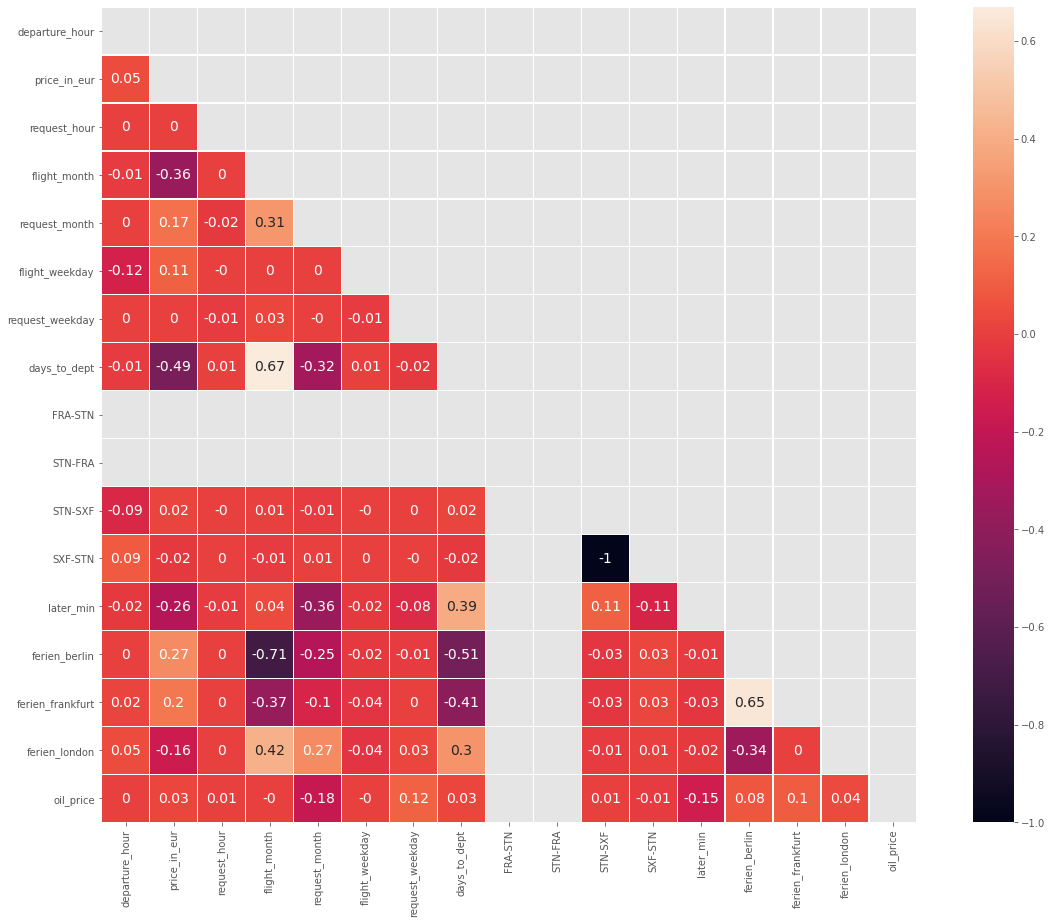

In [ ]:
#nur Flüge von und nach Berlin
df_b=df[(df["STN-SXF"]==1)|(df["SXF-STN"]==1) ]
corr = df_b.corr()
corr = corr.round(2)

fig, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, square = True, linewidths = 0.5, annot=True, annot_kws={"size": 14}, cmap="rocket")

* Es zeigt sich, dass die Ferien in Frankfurt laut Modell Auswirkungen auf die Flugpreise in Berlin haben
* Sinnvoll & logisch?
* Sonst nur geringfügige Änderungen

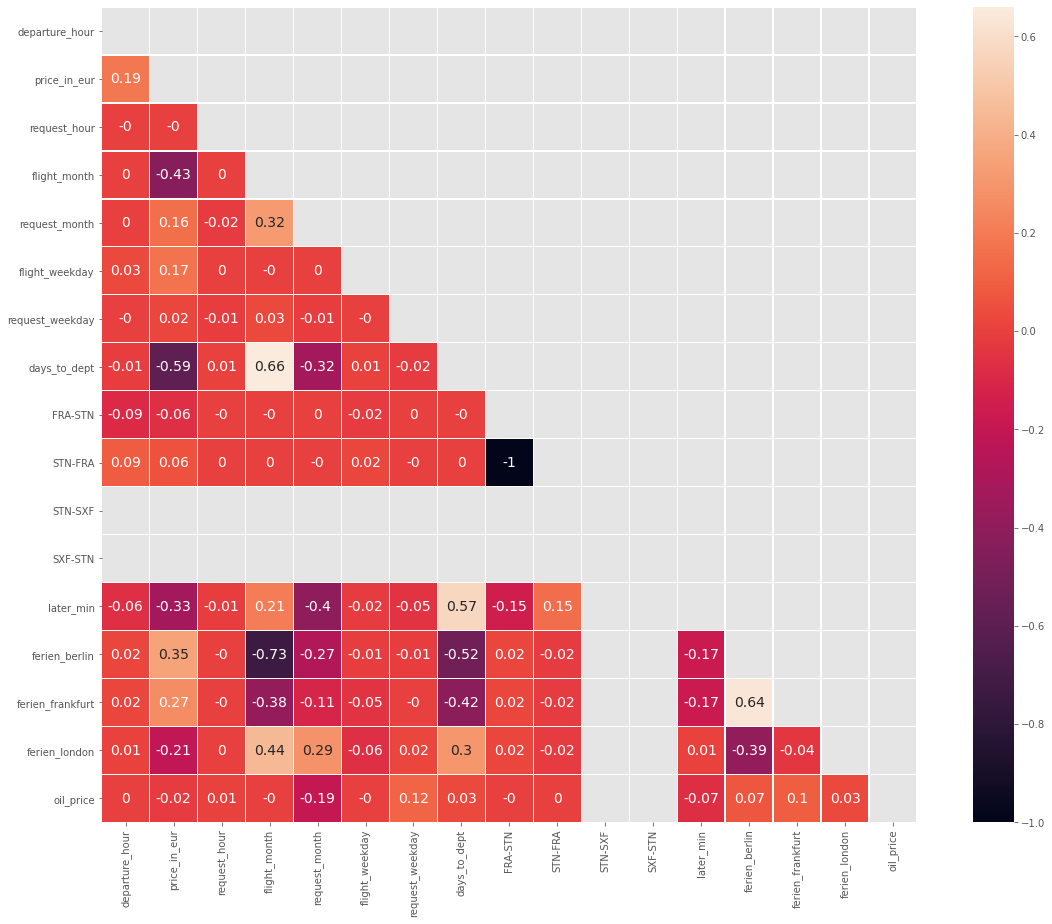

In [ ]:
#nur Flüge von und nach Frankfurt
df_f=df[(df["STN-FRA"]==1)|(df["FRA-STN"]==1) ]
corr = df_f.corr()
corr = corr.round(2)

fig, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask = mask, square = True, linewidths = 0.5, annot=True, annot_kws={"size": 14}, cmap="rocket")

* Es zeigt sich, dass die Ferien in Berlin laut Modell starke Auswirkungen auf die Flugpreise in Frankfurt haben
* Sinnvoll & logisch?
* Sonst nur geringfügige Änderungen

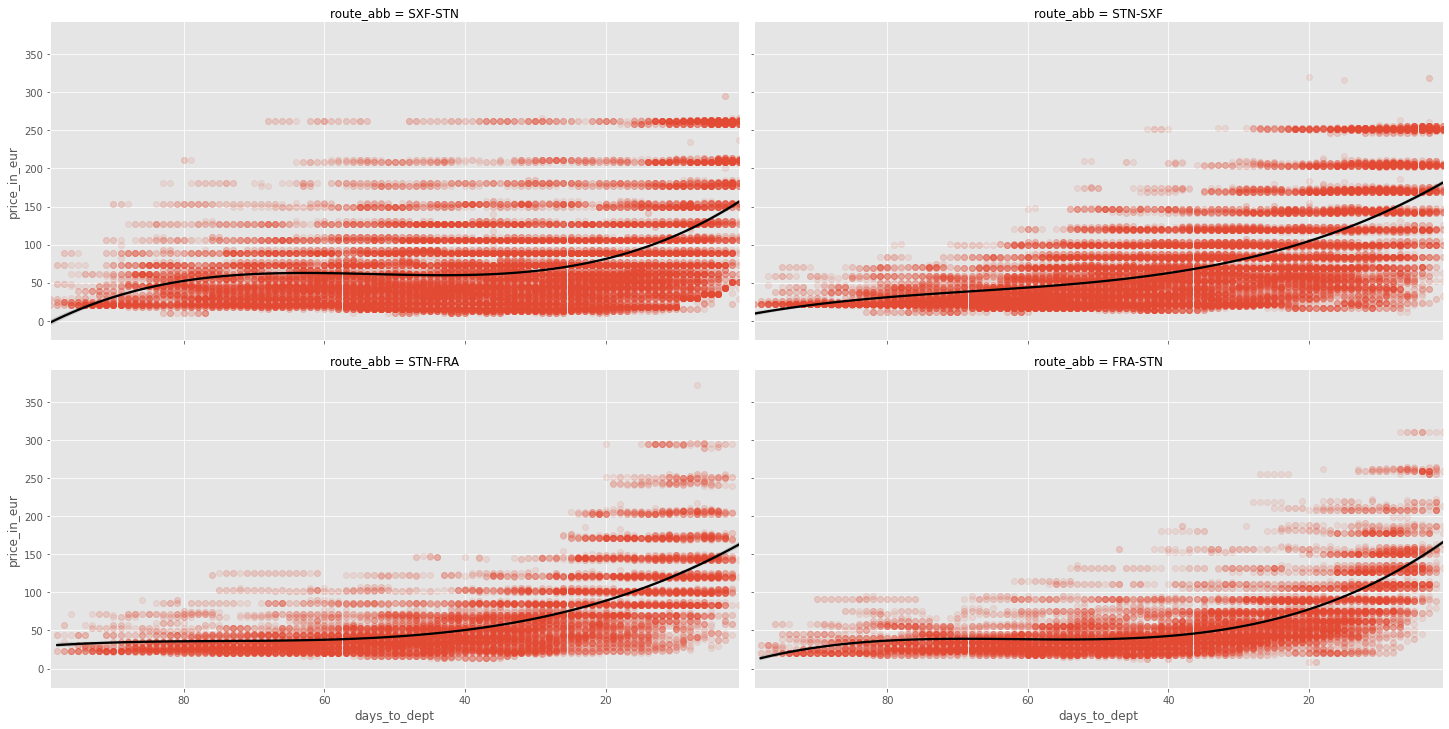

In [ ]:
#sns.lmplot(x='days_to_dept', y='price_in_eur', data=df, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
sns.lmplot(x='days_to_dept', y='price_in_eur', data=df, col='route_abb', order=3, col_wrap=2, scatter_kws={'alpha':0.1},line_kws={'color': 'black'}, palette=sns_palette, height=5, aspect=2)
plt.gca().invert_xaxis()

* Es wurden polinomische Regressionslinien dritten Grades in einem Scatterplot (Price by Days to Departure) berechnet
* Die Preise aller Routen steigen sobald die Tage bis zum Flug sinken

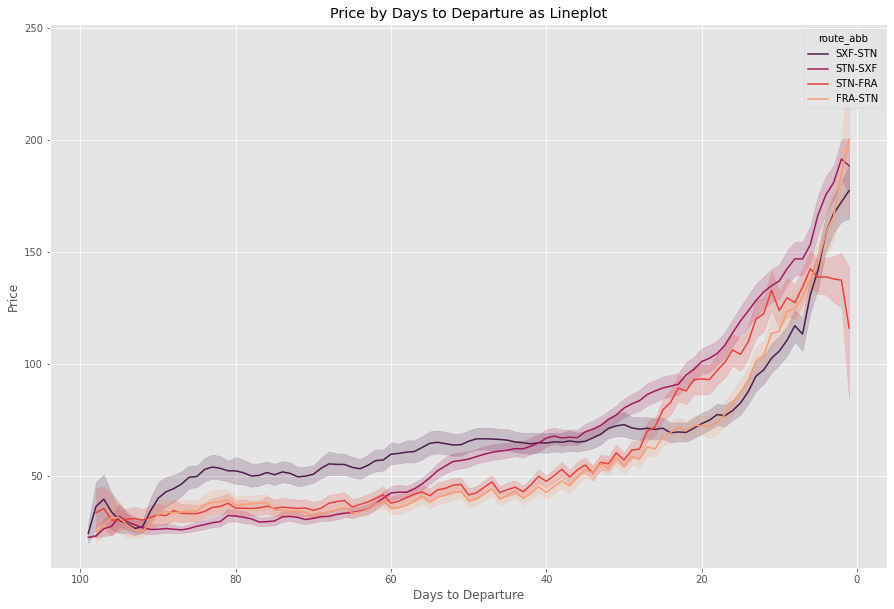

In [ ]:
fig, ax = set_fig_ax('Price by Days to Departure as Lineplot', 'Days to Departure', 'Price')
ax = sns.lineplot(x='days_to_dept', y='price_in_eur', hue='route_abb', data=df, palette=sns_palette)
plt.gca().invert_xaxis()

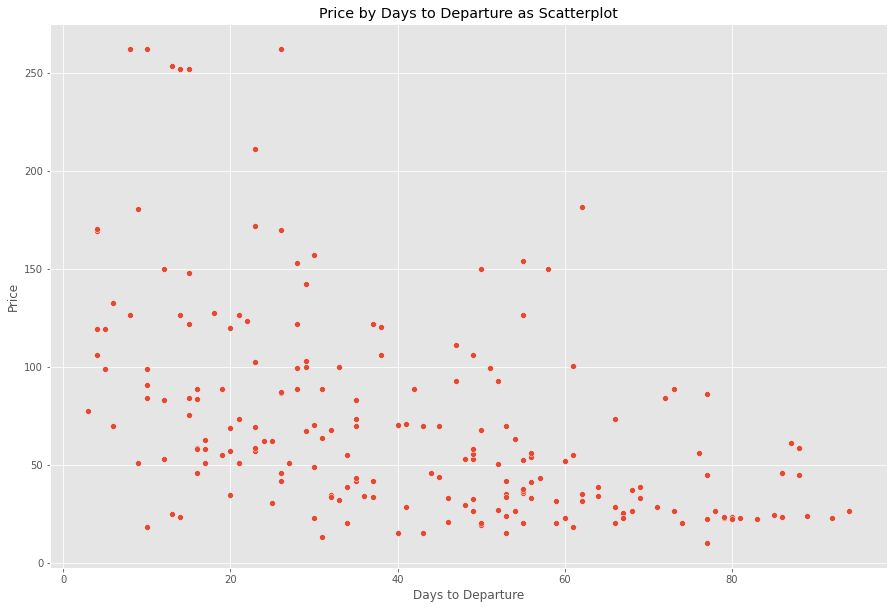

In [ ]:
sample=df.sample(200)
fig, ax = set_fig_ax('Price by Days to Departure as Scatterplot', 'Days to Departure', 'Price')
sns.scatterplot(x='days_to_dept', y='price_in_eur', data=sample,palette=sns_palette)

* Auf jeder Strecke ist der Flug umso biliger, je früher er gebucht wird

In [ ]:
#Gruppieren der Daten nach Abflugsstunde und Sortieren nach Preis
df_group_dep = df.groupby("departure_hour", as_index=False)[['price_in_eur']].mean().sort_values(by='departure_hour')

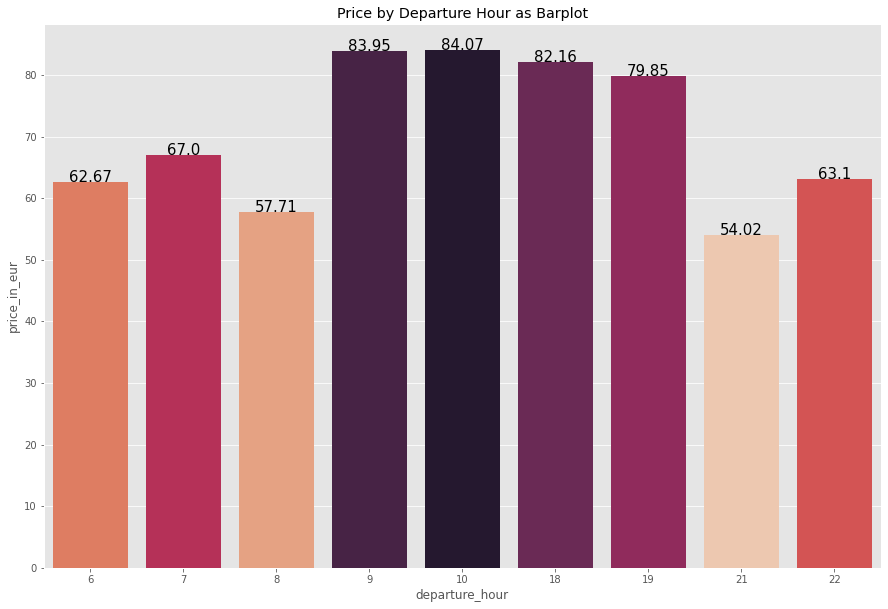

In [ ]:
fig, ax = set_fig_ax('Price by Departure Hour as Barplot', 'Departure Hour', 'Price')
pal = sns.color_palette(sns_palette, len(df_group_dep))
rank = df_group_dep['price_in_eur'].values.argsort().argsort()
ax = sns.barplot(x='departure_hour', y='price_in_eur', data=df_group_dep, palette=np.array(pal[::-1])[rank])
for index, row in df_group_dep.iterrows():
  ax.text(row.name, row.price_in_eur, round(row.price_in_eur,2), color='black', ha="center", fontsize=15)

* Zu Randzeiten sind die Flüge am günstigsten

In [ ]:
df.groupby('route_abb', as_index=False)[['route_abb', 'price_in_eur']].mean().sort_values('price_in_eur')

,route_abb,price_in_eur
0,FRA-STN,61.452478
1,STN-FRA,67.568247
3,SXF-STN,74.786128
2,STN-SXF,77.381973


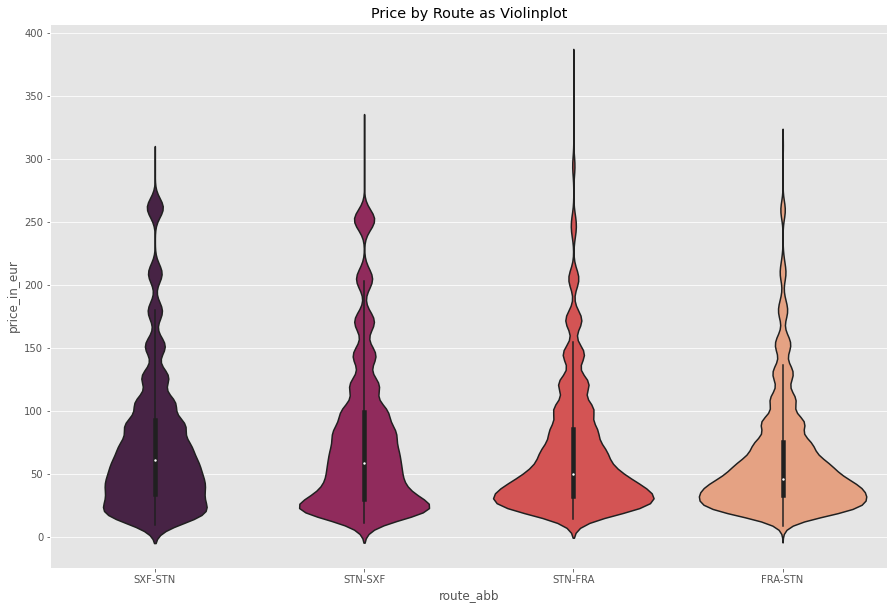

In [ ]:
fig, ax = set_fig_ax('Price by Route as Violinplot', 'Route', 'Price')
ax = sns.violinplot(x='route_abb', y='price_in_eur', data=df, palette=sns_palette, showfliers=False)

* Flüge nach Berlin sind teurer als Flüge nach Frankfurt

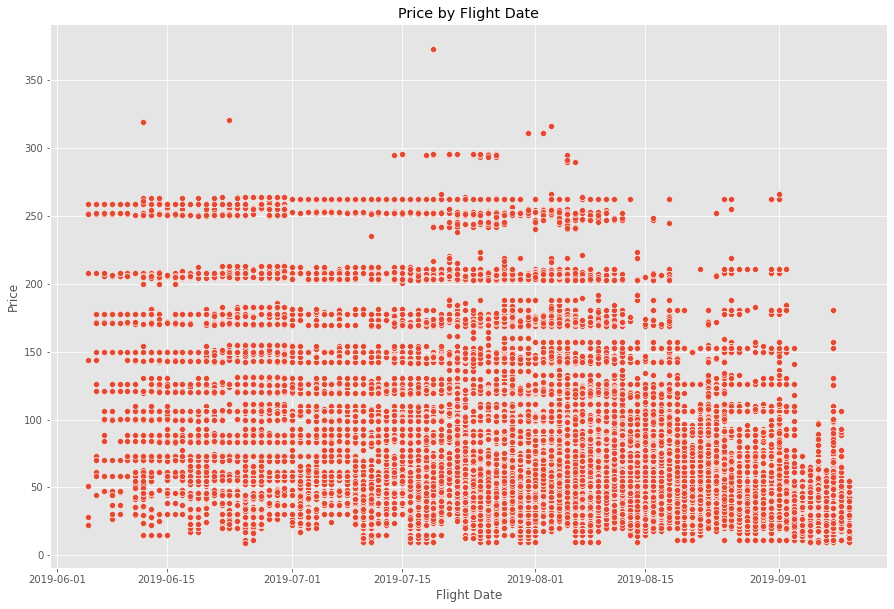

In [ ]:
fig, ax = set_fig_ax('Price by Flight Date', 'Flight Date', 'Price')
sns.scatterplot(x='flight_date', y='price_in_eur', data=df,palette=sns_palette)

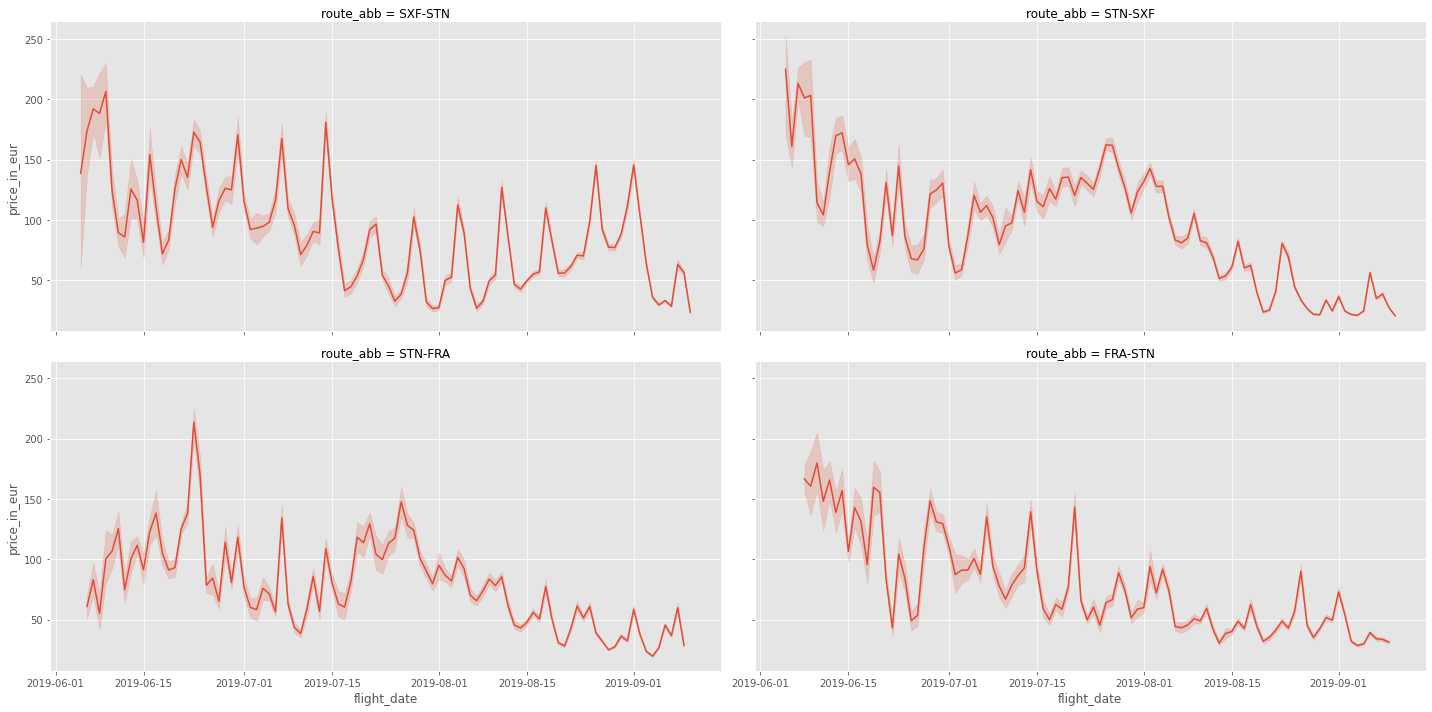

In [ ]:
g=sns.FacetGrid(df,col="route_abb",col_wrap=2,height=5,aspect=2)
g.map(sns.lineplot,"flight_date","price_in_eur",palette=sns_palette)

* Je später man fliegt, desto günstiger wird der Flug
* Wochentage scheinen einen starken Einfluss auf den Preis zu haben
* Bei den Rückfügen von London nach Deutschland scheinen sich die Ferien bemerkbar zu machen

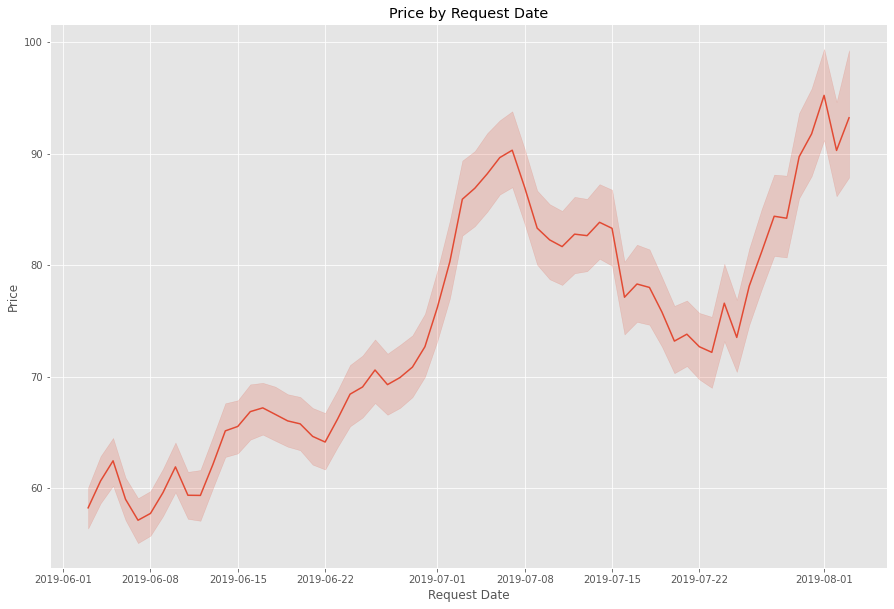

In [ ]:
fig, ax = set_fig_ax('Price by Request Date', 'Request Date', 'Price')
sns.lineplot(x='request_date', y='price_in_eur', data=df, palette=sns_palette)

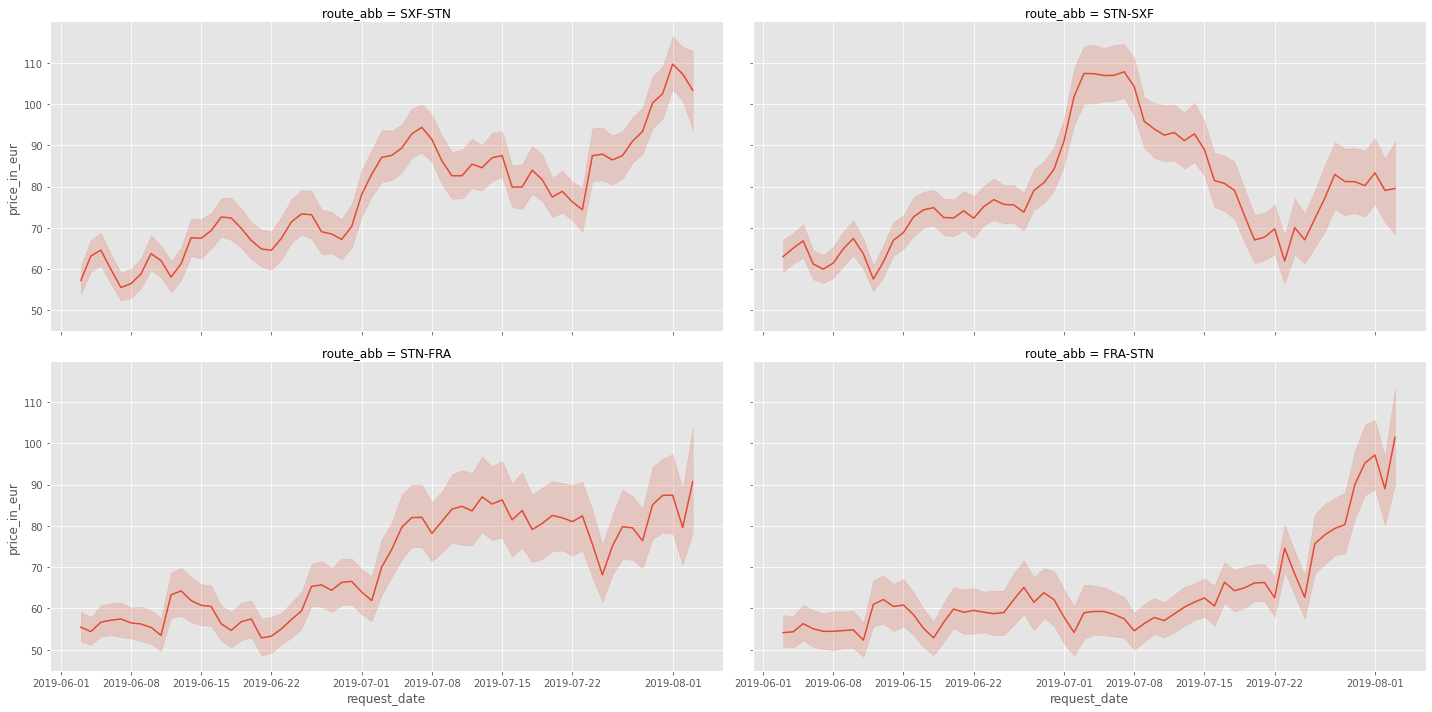

In [ ]:
g=sns.FacetGrid(df,col="route_abb",col_wrap=2,height=5,aspect=2)
g.map(sns.lineplot,"request_date","price_in_eur",palette=sns_palette)

* Keine wirkliche Korrelation zu Tagen sichtbar
* Je später man bucht, deto teurer wird der Flug

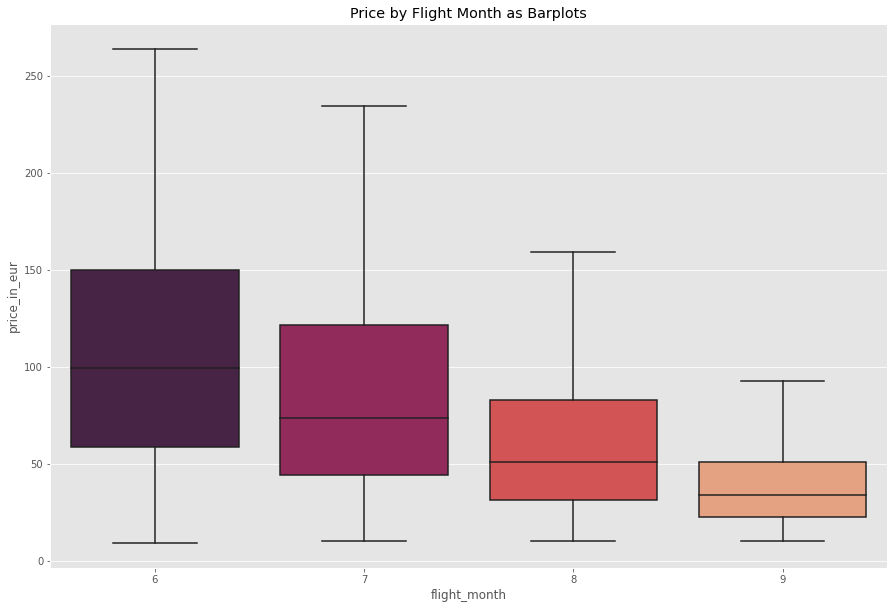

In [ ]:
fig, ax = set_fig_ax('Price by Flight Month as Barplots', 'Flight Month', 'Price')
sns.boxplot(x='flight_month', y='price_in_eur', data=df, showfliers=False, palette=sns_palette)

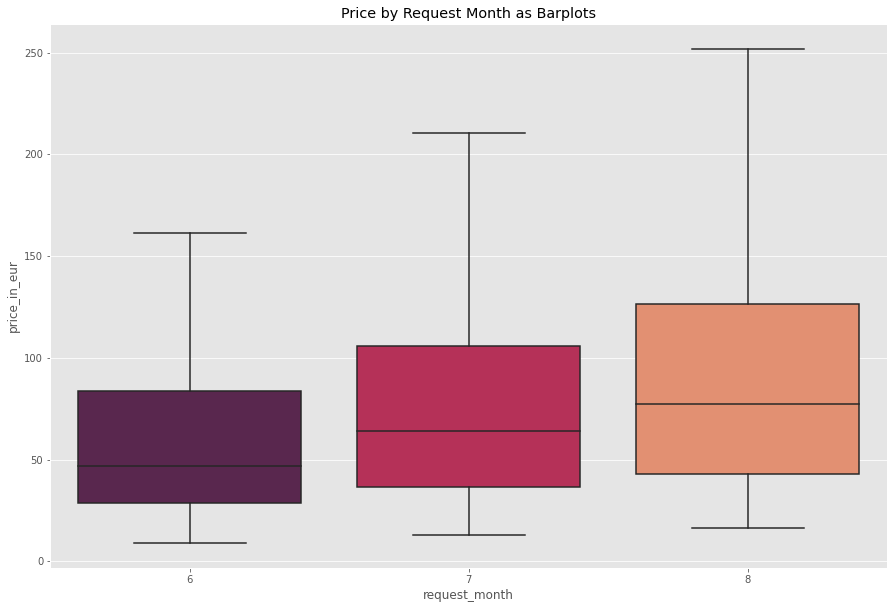

In [ ]:
fig, ax = set_fig_ax('Price by Request Month as Barplots', 'Request Month', 'Price')
sns.boxplot(x='request_month', y='price_in_eur', data=df, showfliers=False, palette=sns_palette)

Bestätigung:
* Flüge im Herbst sind billiger
* Spät gekaufte Flüge sind teurer

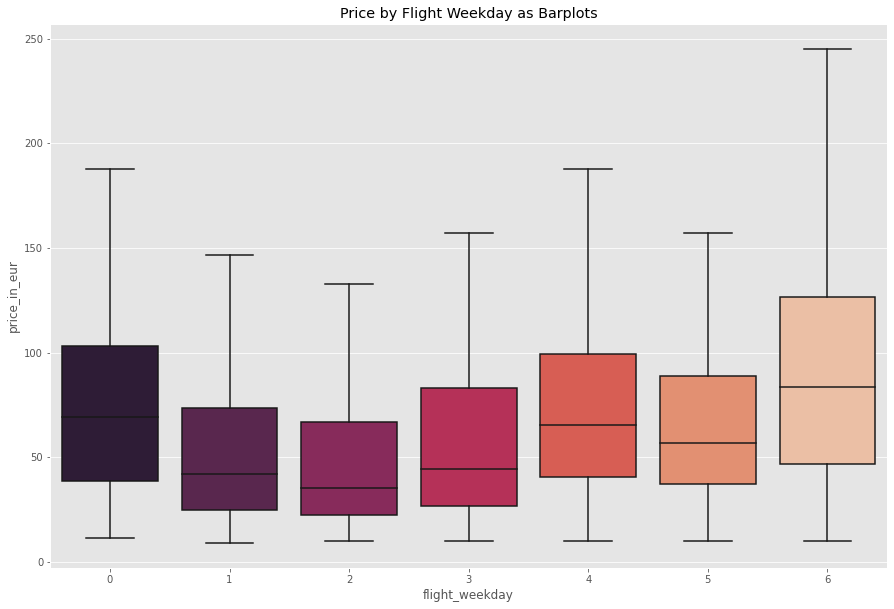

In [ ]:
fig, ax = set_fig_ax('Price by Flight Weekday as Barplots', 'Flight Weekday', 'Price')
sns.boxplot(x='flight_weekday', y='price_in_eur', data=df, showfliers=False, palette=sns_palette)

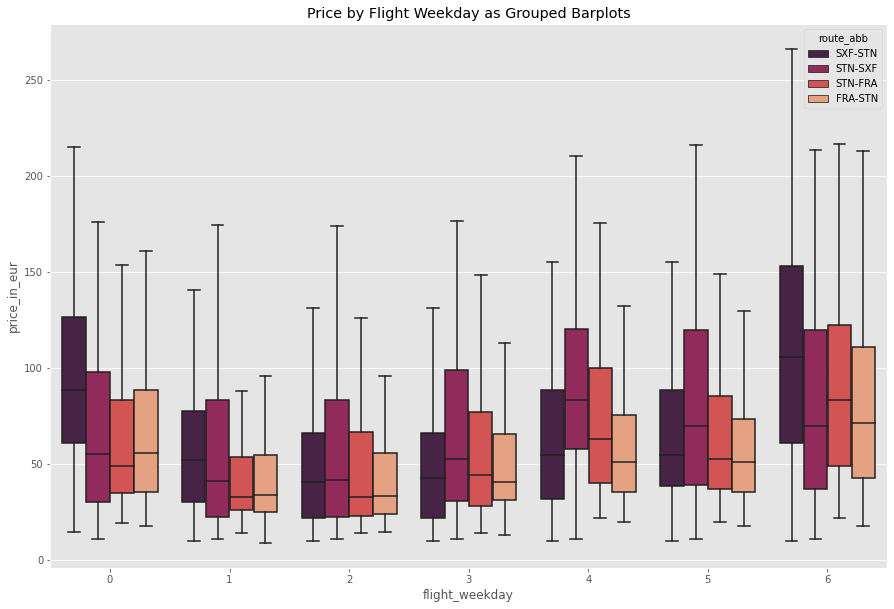

In [ ]:
fig, ax = set_fig_ax('Price by Flight Weekday as Grouped Barplots', 'Flight Weekday', 'Price')
sns.boxplot(x='flight_weekday', y='price_in_eur', data=df, showfliers=False, palette=sns_palette, hue="route_abb")

* Tickets sind Mittwoch am billigsten und Sonntags am teuersten

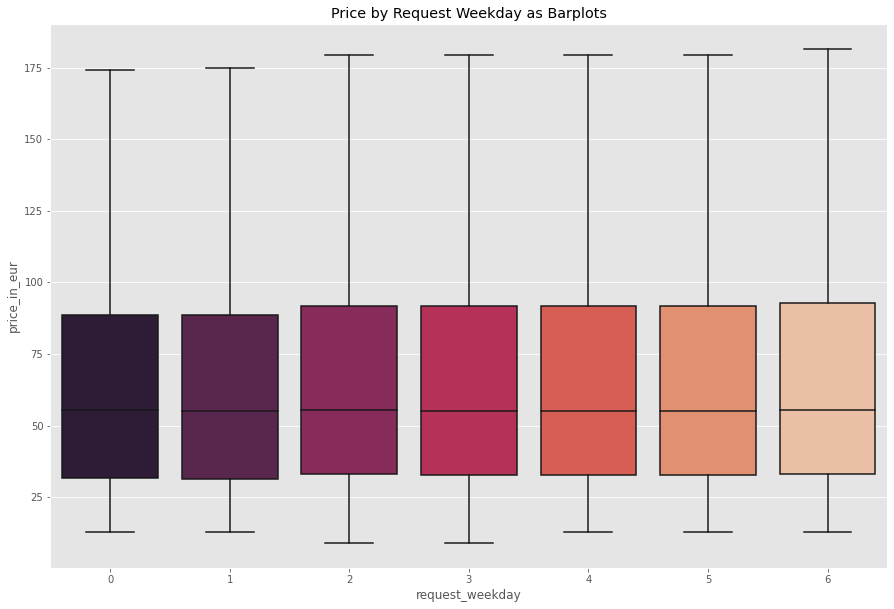

In [ ]:
fig, ax = set_fig_ax('Price by Request Weekday as Barplots', 'Request Weekday', 'Price')
sns.boxplot(x='request_weekday', y='price_in_eur', data=df, showfliers=False, palette=sns_palette)

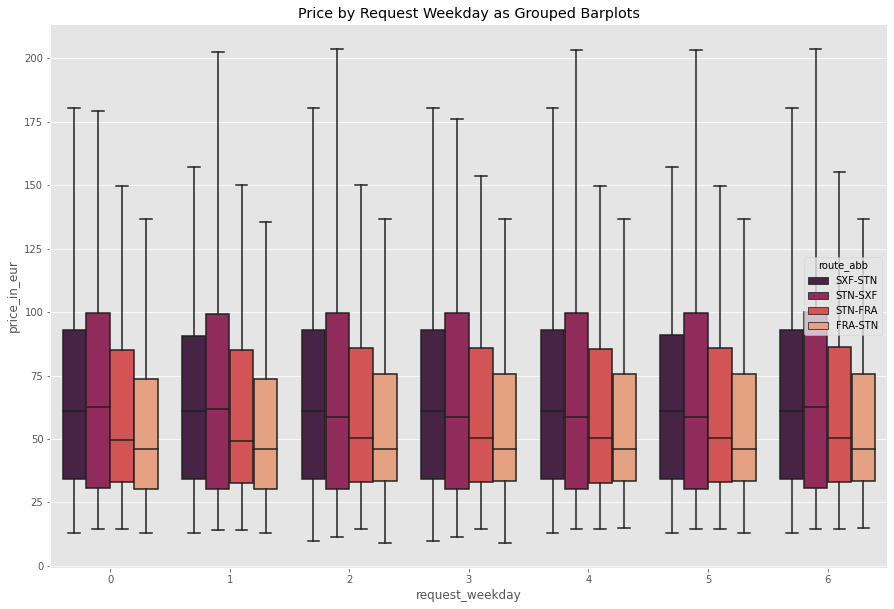

In [ ]:
fig, ax = set_fig_ax('Price by Request Weekday as Grouped Barplots', 'Request Weekday', 'Price')
sns.boxplot(x='request_weekday', y='price_in_eur', data=df, showfliers=False, palette=sns_palette, hue="route_abb")

* Bestätigung: kein Einfluss zwichen Request Weekday und Flugpreis

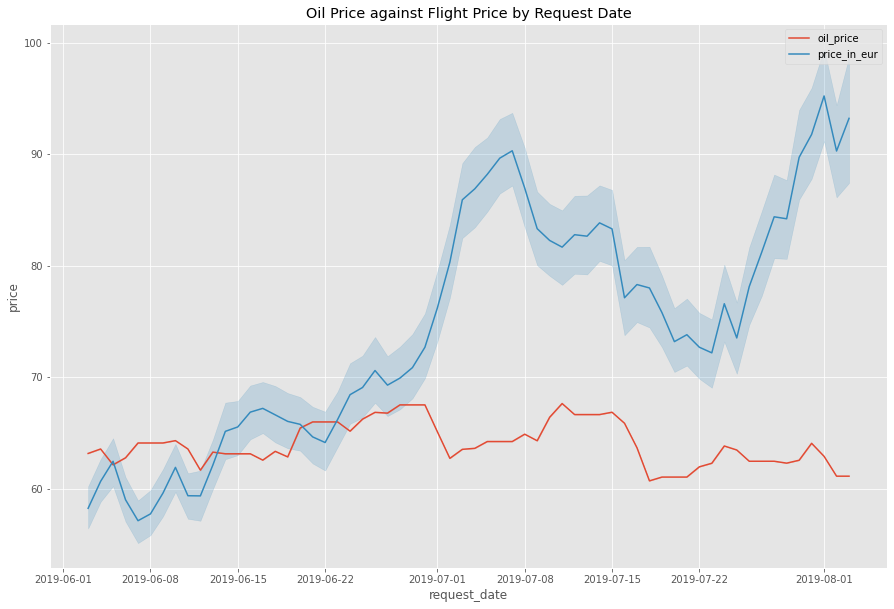

In [ ]:
fig, ax = set_fig_ax('Oil Price against Flight Price by Request Date', 'Request Date', 'Price')
ax = sns.lineplot(x='request_date', y='oil_price', data=df, palette=sns_palette, label="oil_price")
ax = sns.lineplot(x='request_date', y='price_in_eur', data=df, palette=sns_palette, label="price_in_eur")
ax.set(xlabel='request_date', ylabel='price')
ax.legend()

* Bestätigung: keine Korrelation zwischen Ölpreis und Preis des Flugtickets

In [ ]:
df.groupby("request_hour", as_index=False)[['price_in_eur']].mean().sort_values(by='request_hour')

,request_hour,price_in_eur
0,11,71.945308
1,23,71.985017


* Bestätigung: kein Korrelation zwischen Request Hour und Preis des Flugtickets

## Zusammenfassung

Zusammenhänge gibt es zwischen Preis und:

* Land --> Flüge von London nach Deutschland sind billiger als umgekehrt
* Stadt --> Flüge nach Frankfurt sind billiger als nach Berlin
* Zeit bis zur Abreise --> je früher ein Flug gebucht wird, desto billiger ist er
* Abflug Uhrzeit --> Randzeiten (besonders früh und spät) sind billiger als angenehmere Uhrzeiten
* Abflug Datum --> im Sommer sind die Flugpreise deutlich höher als im Herbst
* Buchungswochentag --> Mittwochs scheinen die Flugtickets grundsätzlich am günstigsten zu sein. Zum ende der Woche sind sie im Mittel etwas teurer und die Varianz ist deutlich größer
* Ferien Berlin --> Flüge von und nach Berlin sind in den Ferien dort teurer
* Ferien Frankfurt --> Flüge von und nach Frankfurt sind in den Ferien dort teurer
* Ferien London --> Flüge sind dabei günstiger; könnte auch an dem späten Ferien Zeitraum liegen